# Bank Customer Churn Analysis and Prediction
In this notebook we will perform a comprehensive analysis of bank customer churn data, including data exploration, preprocessing, model training, and evaluation. We'll build and compare two models to predict which customers are likely to leave the bank.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib
import os

In [2]:
# Random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration
First, let's load the dataset and explore its characteristics.

In [3]:
# Upload the dataset file
from google.colab import files
uploaded = files.upload()

Saving Bank Customer Churn.csv to Bank Customer Churn.csv


In [4]:
# Loading the data using pandas df
df = pd.read_csv('Bank Customer Churn.csv')

In [5]:
# Display basic information
print("\nData Exploration:")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


Data Exploration:
Dataset shape: (10000, 12)

First 5 rows:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  


The dataset consists of 10,000 rows and 12 columns, indicating that we have 10,000 customer records with 12 associated features (including the target variable churn).

First 5 Rows:
Features include a mix of demographic attributes (e.g., age, gender, country), account-related details (e.g., balance, products_number, tenure, credit_card, active_member), and a financial metric (estimated_salary).

The churn column is binary (0 or 1), indicating whether the customer churned.

Some customers have a balance of 0, suggesting they might not be actively using their accounts.

credit_card and active_member are likely binary indicators (0 = No, 1 = Yes).

Customers hold between 1 and 3 products, based on products_number.

In [6]:
# Display detailed information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None


No missing values are present in any of the columns (Non-Null Count = 10000 for all), which means we don't need to perform imputation or drop any rows/columns due to nulls. This allows us to proceed confidently to the next steps in data analysis and preprocessing.

Data types:

float64: 2 columns – likely continuous features (balance, estimated_salary).

int64: 8 columns – includes both discrete numerical features and binary indicators (credit_score, age, tenure, products_number, credit_card, active_member, churn, customer_id).

object: 2 columns – country and gender, which are categorical and will require encoding before feeding into machine learning models.

The customer_id column appears to be a unique identifier and does not carry predictive value, so it can be dropped during modeling.

In [7]:
print(df.describe())

        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.4

Churn Rate:

The mean churn value is 0.2037, indicating that ~20.37% of customers have churned, while the remaining ~79.63% stayed. This confirms a class imbalance that we’ll need to address during modeling (e.g., using SMOTE or class weighting).

Age:

Mean age is ~39 years, with a wide range from 18 to 92.

The standard deviation (~10.5) suggests a good amount of variability across age groups.

Credit Score:

Ranges from 350 to 850, which aligns with typical credit score scales.

The average customer has a credit score around 650, but the wide range suggests the need to assess whether lower credit scores are correlated with higher churn.

Balance:

Notably, 25% of customers have a balance of 0, indicating they might not be actively using their accounts.

The maximum balance is 250898.09, while the mean is ~76.5K, showing significant variation.

These inactive customers with zero balance may contribute disproportionately to churn.

Tenure:

Tenure (number of years with the bank) ranges from 0 to 10, with a median of 5 years.

It appears fairly evenly distributed; we’ll later assess if loyalty correlates with lower churn.

Estimated Salary:

Salaries range from ~11 to 200K, with a median around 100K, showing a broad economic representation.

Product Engagement:

Most customers have 1 product (25%, 50%, and 75% percentiles all at 1), which may indicate low engagement.

We'll investigate whether customers with fewer products are more likely to churn.

Credit Card & Active Member (binary features):

Around 70.5% have a credit card, and 51.5% are active members.

The balance in these features allows us to examine whether being an active member or holding a credit card reduces churn risk.

# 2. Data Visualization
## Now, let's visualize various aspects of the data to gain insights about factors affecting churn.

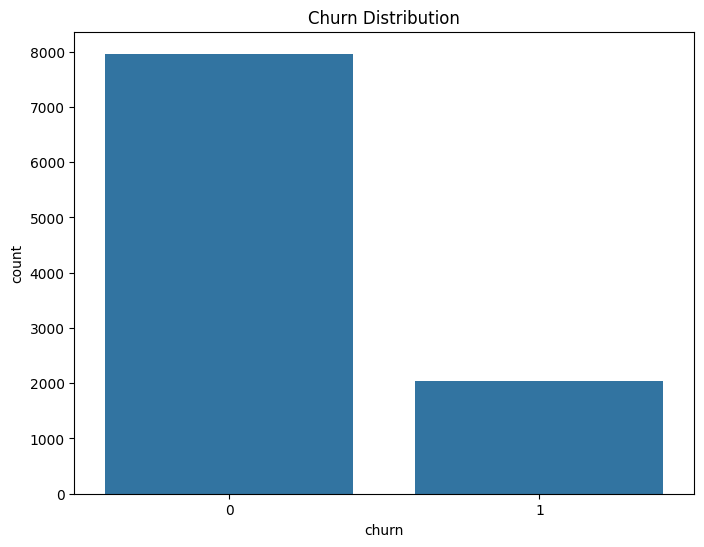

In [8]:
# Create a directory for saving figures
if not os.path.exists('figures'):
    os.makedirs('figures')

# Plot churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.savefig('figures/churn_distribution.png')
plt.show()

The bar chart above shows the distribution of churned (1) vs. non-churned (0) customers:

A large majority of customers (≈ 80%) are non-churned, represented by class 0.

Only about 20% of the customers are churned, represented by class 1.

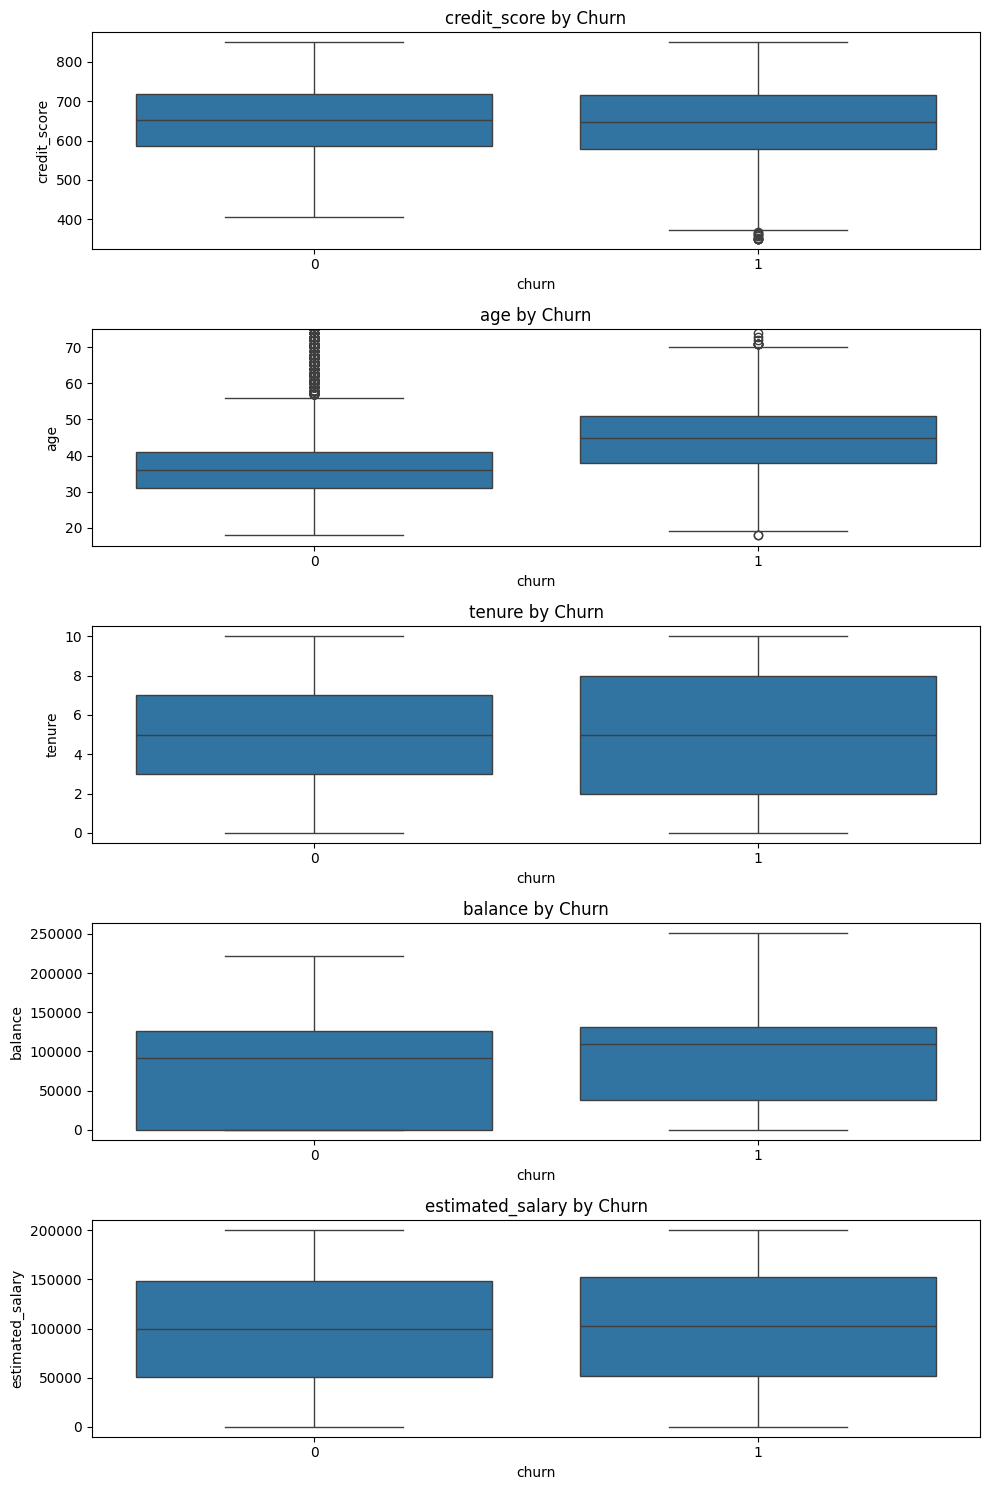

In [35]:
# Define the list of numerical features to analyze in relation to churn
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 15))

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='churn', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Churn')
    # Adjusted y-axis for the 'age' plot
    if feature == 'age':
        axes[i].set_ylim(15, 75)  # Adjusted y-limits for 'age' for better visualization

plt.tight_layout()
plt.savefig('figures/numerical_features_by_churn_adjusted.png')
plt.show()

These box plots visualize the distribution of key numerical features between customers who churned (1) and those who did not churn (0):

1. credit_score by Churn

The median credit score is slightly lower for churned customers.

2. age by Churn

Customers who churn are, on average, older than those who do not. The median age is higher, and the central 50% of ages are also shifted upwards for the churn group.

3. tenure by Churn

No major difference in the distribution of tenure across the two groups.

4. balance by Churn

Both churned and non-churned customers exhibit a wide range of balances, but the medians are similar.

5. estimated_salary by Churn

Distribution is fairly uniform across both groups, with no clear pattern.

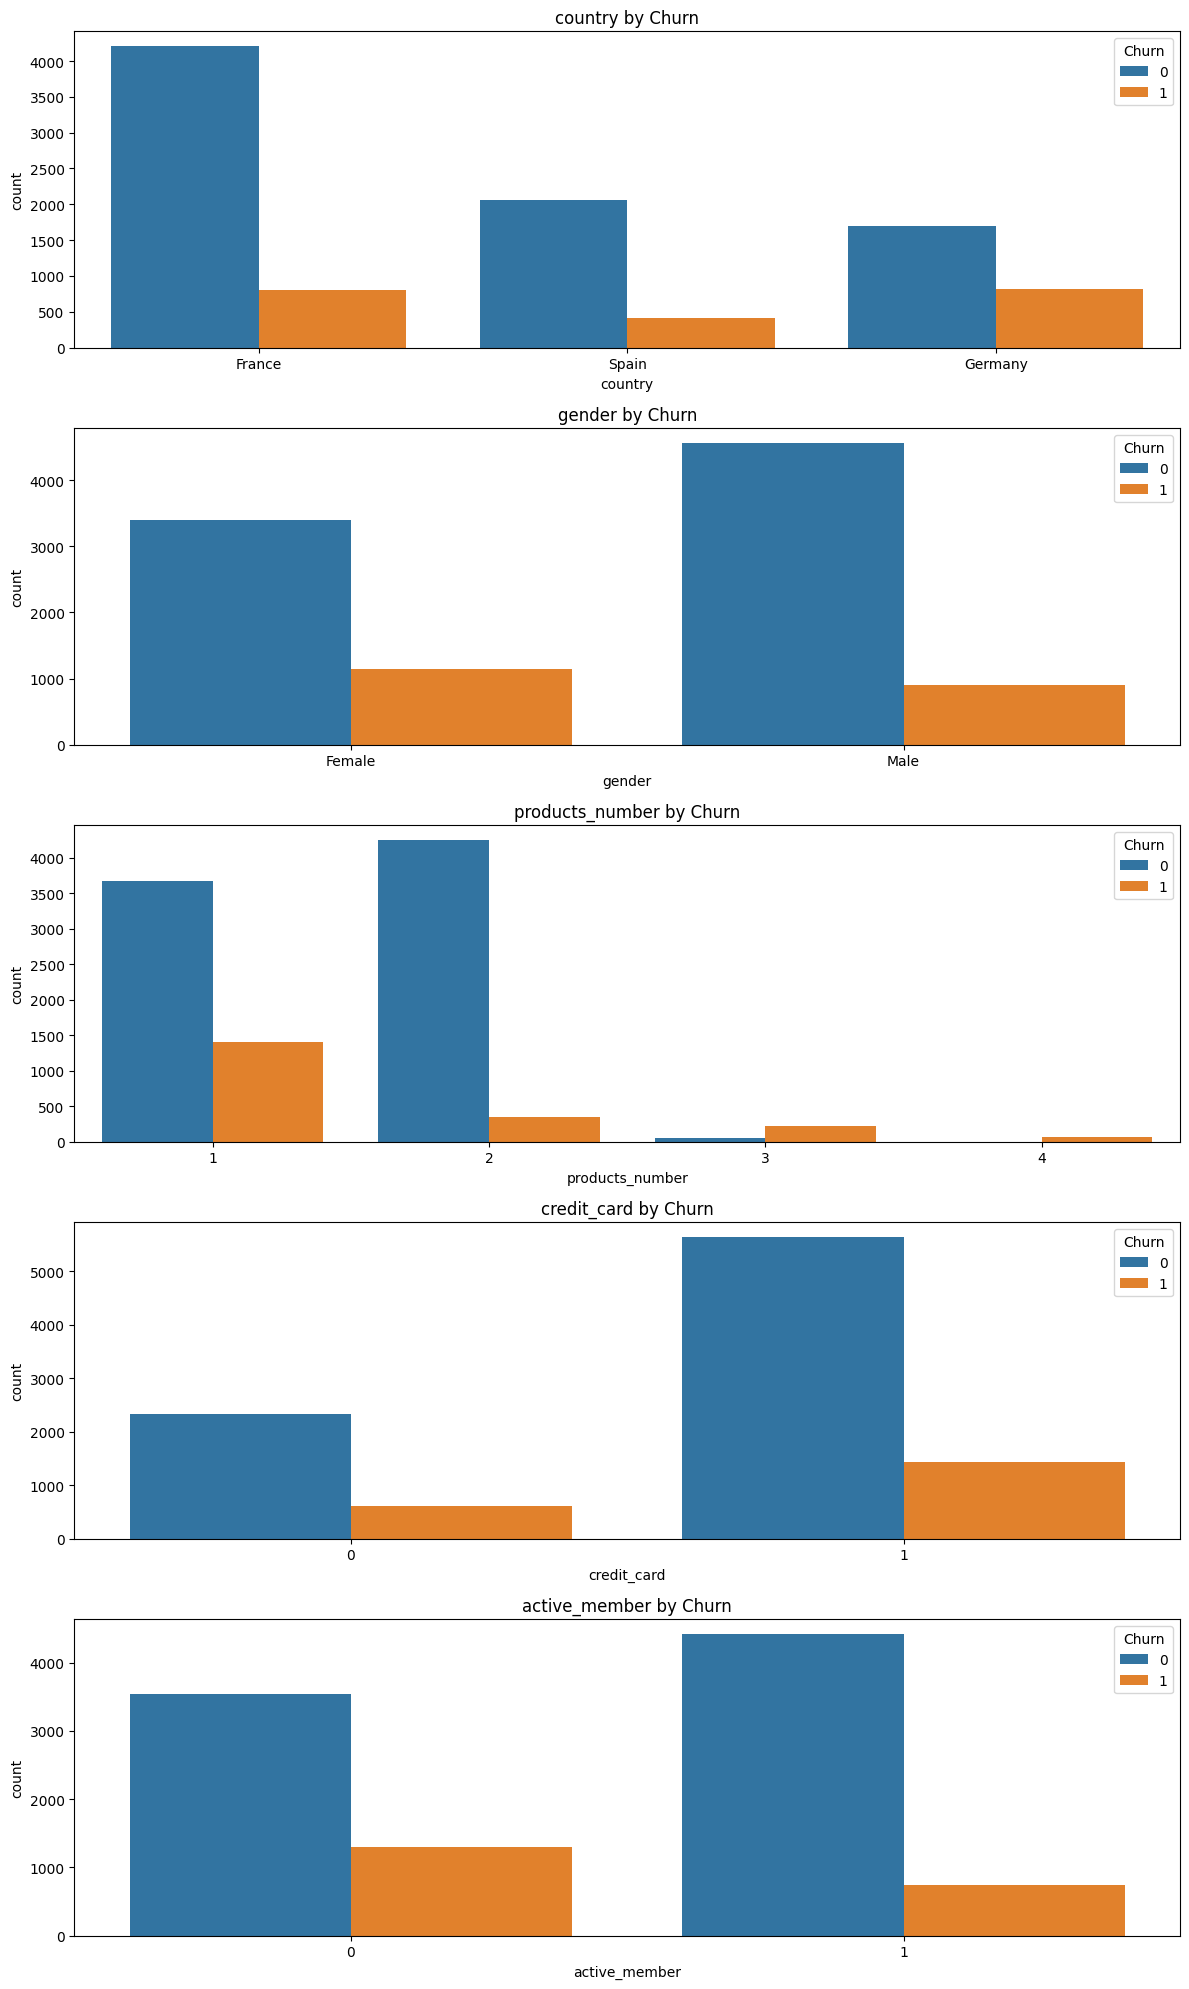

In [10]:
# Categorical features distribution by churn
categorical_features = ['country', 'gender', 'products_number', 'credit_card', 'active_member']
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(12, 20))

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='churn', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Churn')
    axes[i].legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.savefig('figures/categorical_features_by_churn.png')
plt.show()

Country, gender, number of products, and active member status are potentially strong features for predicting churn.

Credit card ownership appears to be a weak predictor.

For modeling purposes, interactions between these categorical features and numerical ones like age and balance may further enhance predictive performance.

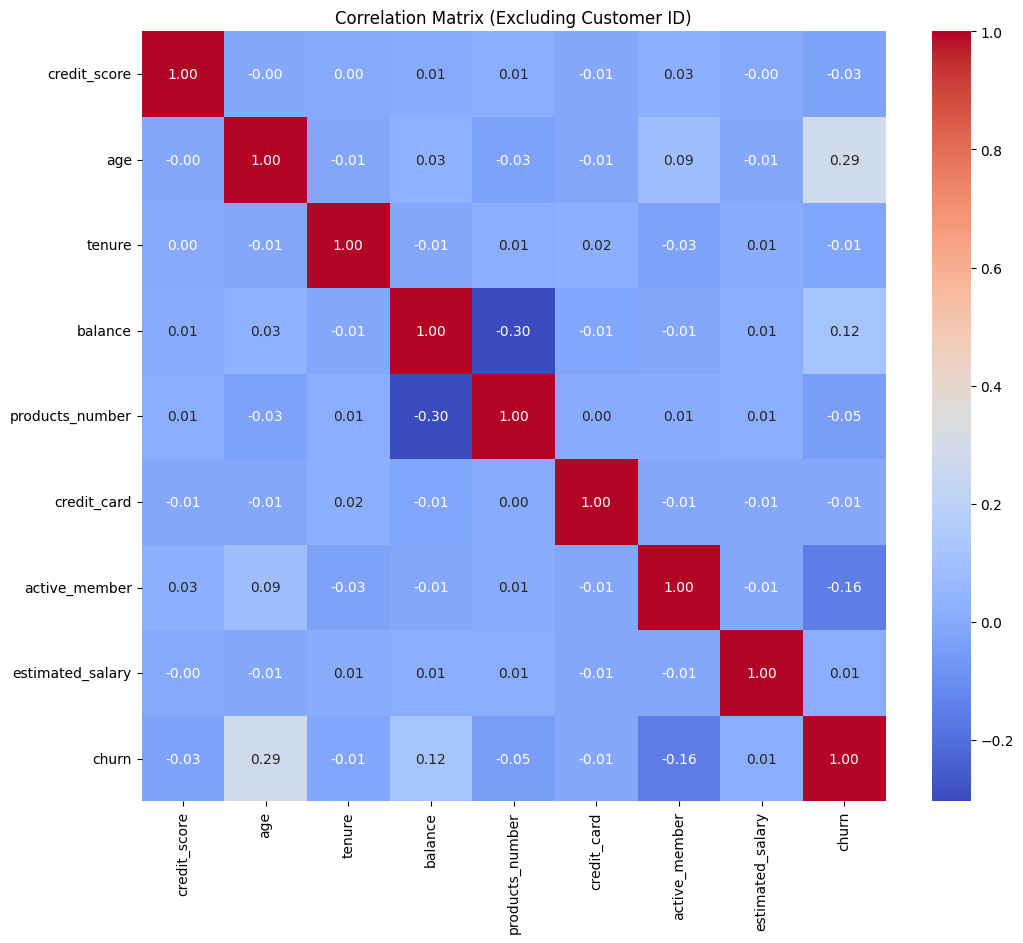

In [30]:
# Correlation matrix
plt.figure(figsize=(12, 10))

# Drop customer_id before selecting numeric types
df_correlation = df.drop('customer_id', axis=1)
numeric_df = df_correlation.select_dtypes(include=['int64', 'float64'])

correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Excluding Customer ID)')
plt.savefig('figures/correlation_matrix_2.png') # Save with a new name
plt.show()

This heatmap shows Pearson correlation coefficients between features and the churn label. We notice:

Correlation with churn
age shows the strongest positive correlation with churn (+0.29):
→ Older customers are more likely to churn.

active_member shows the strongest negative correlation (−0.16):
→ Customers who are active members are least likely to churn.

balance and products_number show weak correlations (+0.12 and −0.05, respectively).

credit_score, tenure, estimated_salary, and credit_card have very low or near-zero correlation with churn.

Inter-feature Correlations
balance and products_number are negatively correlated (−0.30)—possibly indicating higher product usage relates to lower balances.

Most features are weakly correlated with each other, indicating low multicollinearity, which is good for modeling.

Features like age, active_member, and balance might carry predictive value for churn.

The low inter-feature correlations suggest no urgent need for dimensionality reduction techniques like PCA.

While credit_score and tenure don't show strong linear correlation with churn, they may still contribute non-linear relationships in tree-based models.

# 3. Data Preprocessing
## Now we'll prepare our data for modeling, including feature encoding and addressing class imbalance if it exists.

In [12]:
# We will drop customer_id as it's just an identifier
X = df.drop(['customer_id', 'churn'], axis=1)
y = df['churn']

In [13]:
# Define categorical and numerical features
categorical_features = ['country', 'gender']
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number',
                      'credit_card', 'active_member', 'estimated_salary']

In [14]:
# Create a preprocessing pipeline using ColumnTransformer
# This will apply different transformations to numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to numerical features
        # StandardScaler standardizes the data to have mean = 0 and std deviation = 1
        ('num', StandardScaler(), numerical_features),

        # Apply OneHotEncoder to categorical features
        # drop='first' avoids multicollinearity by dropping the first category from each feature
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Split the dataset into training and testing sets
# X: feature matrix (excluding customer_id and churn)
# y: target vector (churn)
# test_size=0.2: 20% of data is reserved for testing
# random_state=42: ensures reproducibility
# stratify=y: ensures the class distribution (churned vs. not churned) is similar in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Let's see the class distribution
print(f"Original class distribution: {np.bincount(y_train)}")

Original class distribution: [6370 1630]


# The dataset is heavily imbalanced as we have established earlier, we will apply SMOTE to address class imbalance

In [16]:
# Apply preprocessing BEFORE SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE to balance classes
print("\nBalancing classes with SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
print(f"Balanced class distribution: {np.bincount(y_train_balanced)}")


Balancing classes with SMOTE...
Balanced class distribution: [6370 6370]


## 4. Exploratory Data Analysis (EDA)

In this section, we'll visualize the data using histograms and scatter plots to gain insights into potential relationships and patterns.

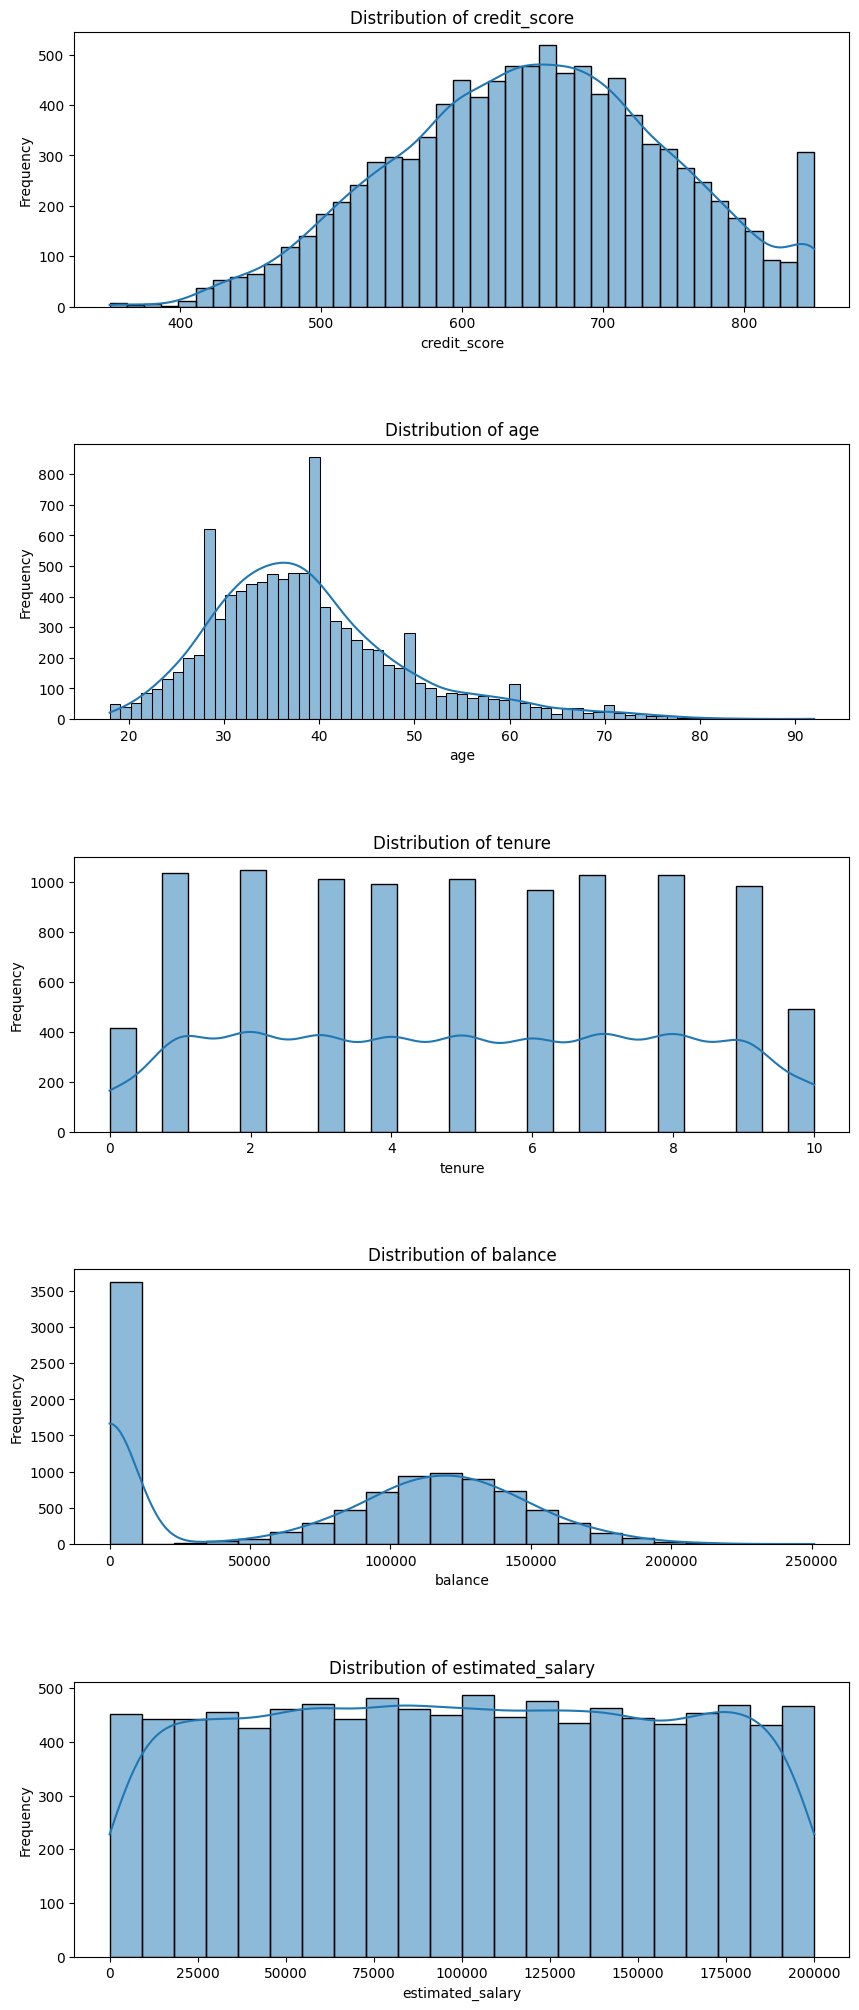

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns you want to visualize
numerical_cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

# Create subplots to display each histogram
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(10, 5 * len(numerical_cols)))
fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

for i, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

1.  **Distribution of Credit Score**

    * Shape: The distribution appears to be approximately normal (bell-shaped) with a slight left skew.
    * Range: Credit scores range from roughly 400 to 850, with most scores concentrated between 600 and 750.
    * Implication: This suggests that most customers have a fair to good credit score, which is typical for many banking populations. The slight left skew indicates a tail of customers with lower credit scores.

2.  **Distribution of Age**

    * Shape: This distribution is right-skewed and multimodal (having multiple peaks).
    * Peaks: There's a prominent peak around the late 20s to early 30s, indicating a large number of customers in this age group. There are smaller peaks at other age ranges as well.
    * Range: The age ranges from around 18 to the early 90s, with a significant drop-off in customers after around 60.
    * Implication: The multiple peaks might suggest different customer segments or product adoption patterns across age groups. The right skew indicates that there are fewer older customers.

3.  **Distribution of Tenure**

    * Shape: The distribution is relatively uniform (flat) across the tenure range.
    * Range: Tenure appears to be measured in whole years, ranging from 0 to 10 years.
    * Implication: This suggests that customers are fairly evenly distributed across different lengths of time with the bank. There isn't a strong tendency for most customers to be either very new or very long-standing.

4.  **Distribution of Balance**

    * Shape: The distribution is heavily right-skewed.
    * Range: Most customers have a balance of 0, with a long tail extending to much higher balances (up to 250,000 or more).
    * Implication: A large proportion of customers may have relatively low or zero balances, while a smaller group holds significantly larger amounts. This could indicate different levels of account activity or customer wealth.

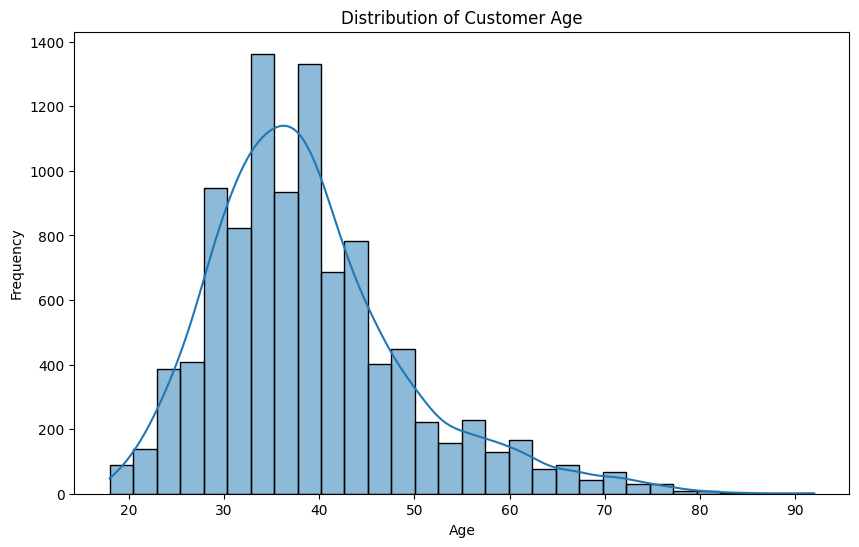

In [18]:
# Histogram of customer age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)  # Adjust bins as needed
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('figures/age_distribution_detailed.png')
plt.show()

**Distribution of Customer Age**

* **Shape:** The distribution is right-skewed and unimodal (having one peak).
* **Peak:** There's a prominent peak around the late 20s to early 40s, indicating a large number of customers in this age group.
* **Range:** The age ranges from around 18 to the early 90s, with a gradual decline in the number of customers after approximately 40.
* **Implication:** The data suggests a concentration of customers in the young to middle-aged adult category.  The right skew indicates that there are fewer older customers.

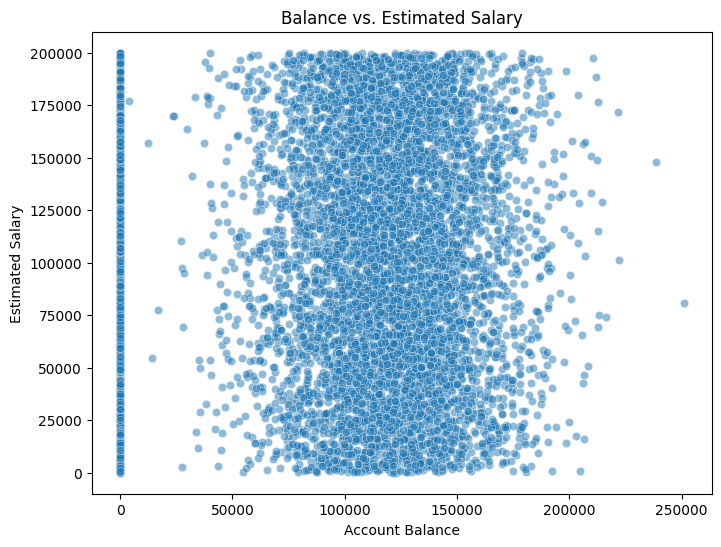

In [32]:
# Scatter plot of balance vs. estimated salary
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='balance', y='estimated_salary', alpha=0.5)
plt.title('Balance vs. Estimated Salary')
plt.xlabel('Account Balance')
plt.ylabel('Estimated Salary')
plt.savefig('figures/balance_vs_salary.png')
plt.show()

**Balance vs. Estimated Salary**

* **Pattern:** The data points are scattered randomly across the plot. There's no clear linear or non-linear relationship visible between account balance and estimated salary.
* **Density:** The points are densely packed in the central region of the plot, indicating a large number of customers with mid-range balances and salaries.
* **Range:** Account balances range from 0 to about 250,000, and estimated salaries range from 0 to about 200,000.
* **Implication:** This suggests that a customer's account balance is not strongly influenced by or indicative of their estimated salary, and vice versa. These two variables appear to vary independently of each other in this dataset.

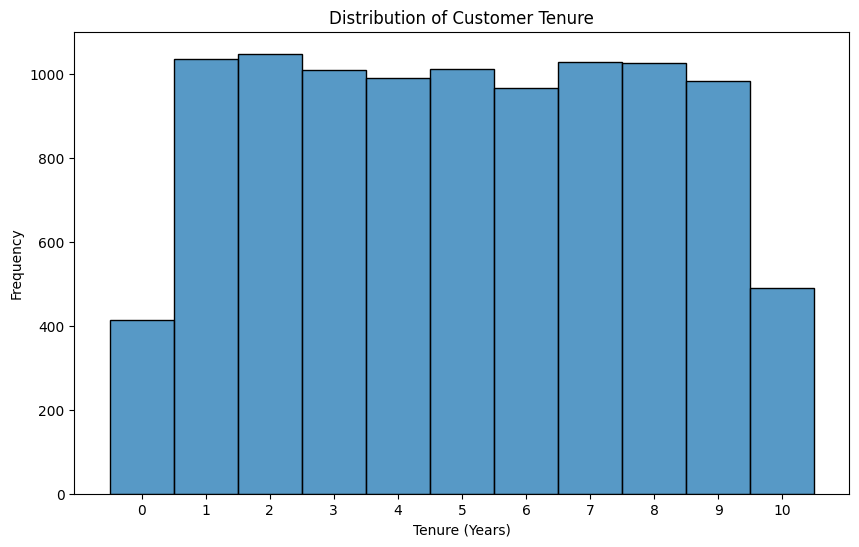

In [20]:
# Histogram of customer tenure
plt.figure(figsize=(10, 6))
sns.histplot(df['tenure'], bins=11, kde=False, discrete=True) # One bin per year
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))  # Ensure ticks at each year
plt.savefig('figures/tenure_distribution.png')
plt.show()

**Distribution of Customer Tenure**

* **Shape:** The distribution is relatively uniform (flat) across the tenure range, with slight variations.
* **Range:** Tenure is measured in whole years, ranging from 0 to 10 years.
* **Implication:** This indicates a roughly equal representation of customers across all tenure lengths.  There's no strong indication of a preference for short-term or long-term customers within this dataset.

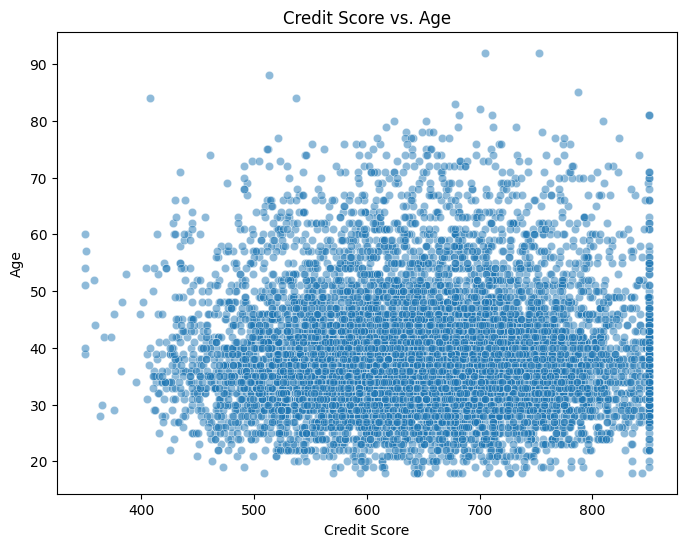

In [21]:
# Scatter plot of credit score vs. age
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='credit_score', y='age', alpha=0.5)
plt.title('Credit Score vs. Age')
plt.xlabel('Credit Score')
plt.ylabel('Age')
plt.savefig('figures/credit_score_vs_age.png')
plt.show()

**Credit Score vs. Age**

* **Pattern:** The data points are scattered, showing no strong linear or non-linear relationship between credit score and age.
* **Density:** A dense cluster of points exists in the mid-range for both credit score (around 550-750) and age (25-50).
* **Range:** Credit scores range from roughly 400 to 850, and age ranges from 20 to 90.
* **Implication:** This suggests that credit score and age don't appear to be strongly correlated in this dataset. Customers of various ages can have a wide range of credit scores, and vice versa.

## 5. Model Training
# We'll train two different models on our data: Random Forest and Gradient Boosting.

In [22]:
# Train models
print("\nTraining improved models...")

# Create models
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train models on balanced data
rf_model.fit(X_train_balanced, y_train_balanced)
gb_model.fit(X_train_balanced, y_train_balanced)


Training improved models...


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

## 6. Model Evaluation
# Now we'll evaluate and compare our models using various metrics.

In [23]:
# Define the evaluation function
def evaluate_model(model, name):
    # Make predictions on processed test data
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Calculate PR AUC (better for imbalanced classes)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot and save confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'figures/confusion_matrix_{name}.png')
    plt.show()

    # Plot and save ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.savefig(f'figures/roc_curve_{name}.png')
    plt.show()

    # Plot PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend(loc="lower left")
    plt.savefig(f'figures/pr_curve_{name}.png')
    plt.show()

    return model, accuracy, roc_auc, pr_auc


Random Forest Results:
Accuracy: 0.8390
ROC AUC: 0.8595
PR AUC: 0.6840

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1593
           1       0.59      0.67      0.63       407

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.76      2000
weighted avg       0.85      0.84      0.84      2000



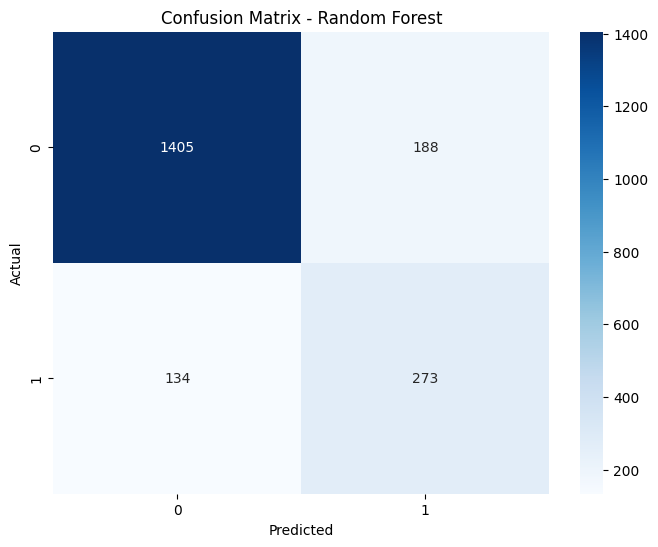

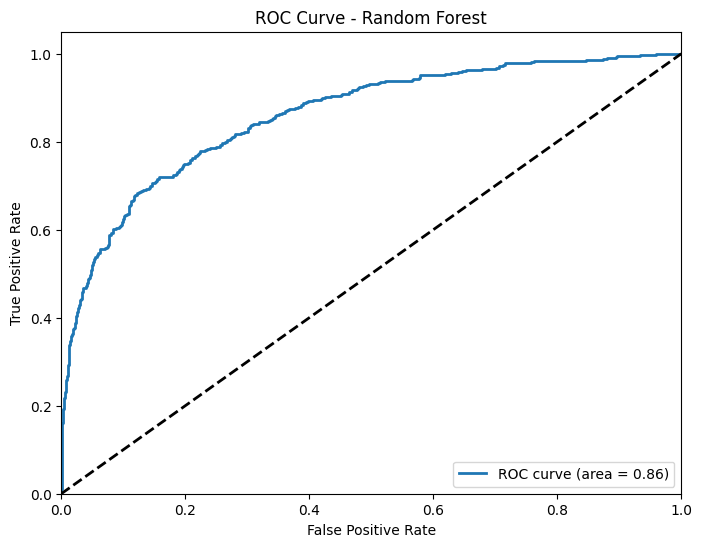

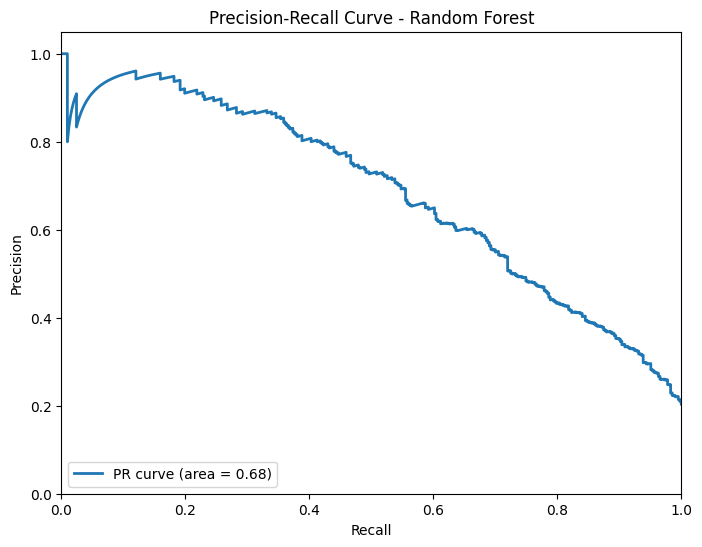

In [24]:
# Evaluate Random Forest model
rf_results = evaluate_model(rf_model, "Random Forest")

# Here’s what each of these outputs tells us about the performance of our Random Forest model:

1. Accuracy: 0.8390
Interpretation:
The model correctly predicts whether a customer will churn or not about 84% of the time on the test set.
Caveat:
Since the dataset is imbalanced (more non-churners than churners), accuracy alone can be misleading. That’s why we look at other metrics too.
2. ROC AUC: 0.8595
Interpretation:
The ROC AUC (Receiver Operating Characteristic Area Under Curve) measures the model’s ability to distinguish between churners and non-churners.
Value Meaning:
0.86 is considered very good. The closer to 1, the better the model is at ranking positive (churn) vs. negative (no churn) cases.
3. PR AUC: 0.6840
Interpretation:
The PR AUC (Precision-Recall Area Under Curve) is especially useful for imbalanced datasets.
Value Meaning:
0.68 means the model is reasonably good at identifying churners, balancing both precision and recall for the minority class.
4. Classification Report
Precision (Churn = 0.59):
Of all customers predicted as churners, 59% actually churned.
(There are some false positives.)
Recall (Churn = 0.67):
Of all actual churners, 67% were correctly identified by the model.
(The model misses about 1 in 3 churners.)
F1-score (Churn = 0.63):
The harmonic mean of precision and recall for churners.
(Balances the trade-off between precision and recall.)
Support:
Number of actual occurrences of each class in the test set.
5. Macro avg / Weighted avg
Macro avg:
Average of precision, recall, and F1-score for both classes, treating them equally.
Weighted avg:
Average of metrics, weighted by the number of samples in each class.
Summary of Inferences
The model is very good at identifying non-churners (precision and recall ~0.9).
The model is moderately good at identifying churners (precision 0.59, recall 0.67).
The model is better at recall (catching churners) than precision (not flagging non-churners as churners).
The ROC AUC and PR AUC indicate strong overall performance, especially for an imbalanced dataset.
There is still room for improvement in reducing false positives and increasing precision for the churn class.
Business Takeaway:
The model can be used to flag customers at risk of churning, but retention efforts should be aware that some flagged customers may not actually churn (false positives). The model is more likely to catch a churner than to miss one, which is often desirable in retention campaigns.


Gradient Boosting Results:
Accuracy: 0.8575
ROC AUC: 0.8576
PR AUC: 0.7072

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.69      0.55      0.61       407

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



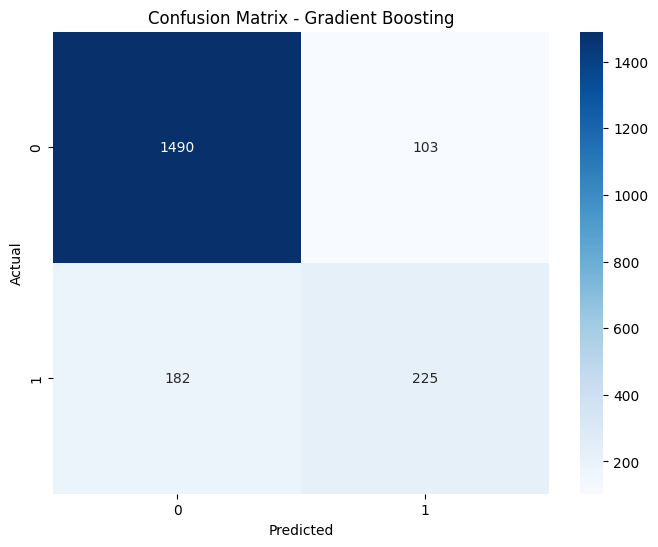

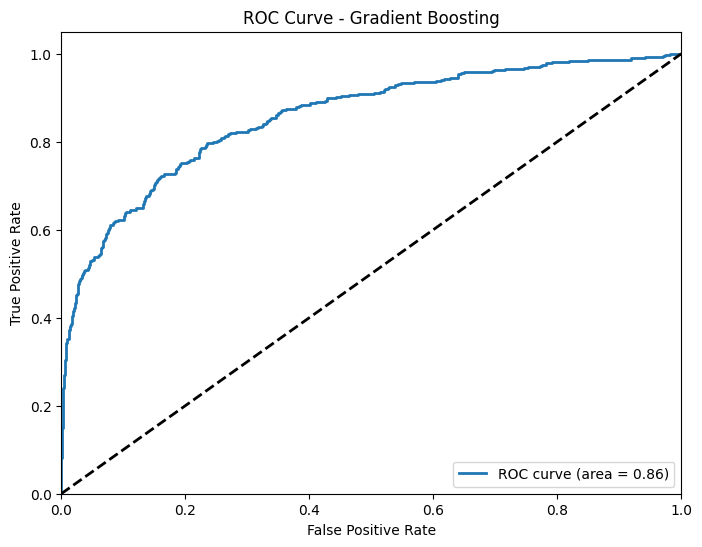

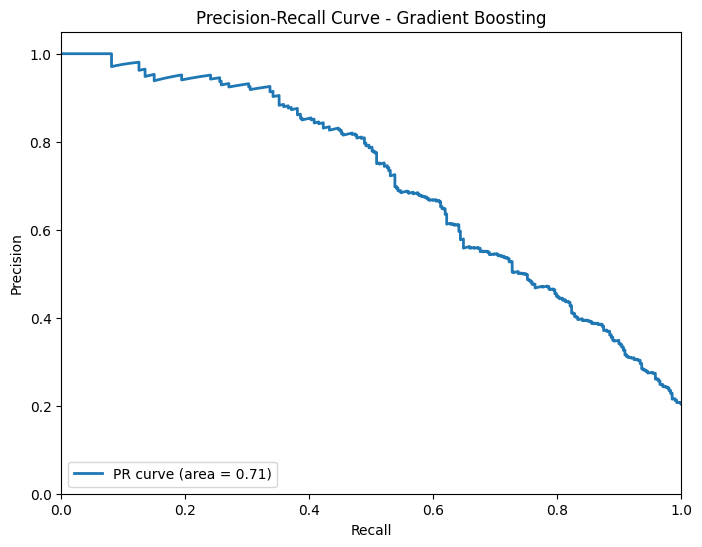

In [25]:
# Evaluate Gradient Boosting model
gb_results = evaluate_model(gb_model, "Gradient Boosting")

# Here’s what each of these outputs tells us about the performance of our Gradient Boosting model:
1. Accuracy: 0.8575
Interpretation:
The model correctly predicts whether a customer will churn or not about 86% of the time on the test set.
Caveat:
As before, accuracy can be misleading for imbalanced datasets, so we look at other metrics too.
2. ROC AUC: 0.8576
Interpretation:
The ROC AUC (Receiver Operating Characteristic Area Under Curve) measures the model’s ability to distinguish between churners and non-churners.
Value Meaning:
0.86 is very good, indicating strong separation between the two classes.
3. PR AUC: 0.7072
Interpretation:
The PR AUC (Precision-Recall Area Under Curve) is especially useful for imbalanced datasets.
Value Meaning:
0.71 is a strong value, showing the model is effective at identifying churners, balancing both precision and recall.
4. Classification Report
Precision (Churn = 0.69):
Of all customers predicted as churners, 69% actually churned.
(Fewer false positives compared to Random Forest.)
Recall (Churn = 0.55):
Of all actual churners, 55% were correctly identified by the model.
(The model misses about 45% of churners, but is more precise when it does flag a churner.)
F1-score (Churn = 0.61):
The harmonic mean of precision and recall for churners.
(Balances the trade-off between precision and recall.)
Support:
Number of actual occurrences of each class in the test set.
5. Macro avg / Weighted avg
Macro avg:
Average of precision, recall, and F1-score for both classes, treating them equally.
Weighted avg:
Average of metrics, weighted by the number of samples in each class.
Summary of Inferences
The model is very good at identifying non-churners (precision 0.89, recall 0.94).
The model is more precise at identifying churners (precision 0.69) than Random Forest, but with slightly lower recall (0.55).
The model is less likely to flag non-churners as churners (fewer false positives).
ROC AUC and PR AUC are both strong, indicating robust performance for an imbalanced dataset.
The model is more conservative in predicting churn (fewer false positives, but also misses more actual churners).
Business Takeaway:
The Gradient Boosting model is more precise in identifying churners, meaning retention efforts will be more focused and less likely to waste resources on customers who would not have churned. However, it will miss more actual churners than the Random Forest model. This model is suitable if the cost of a false positive (unnecessary retention effort) is higher than the cost of a false negative (missed churner). If you want to catch more churners at the expense of more false positives, Random Forest may be preferable.
Visuals:
The confusion matrix shows the model is better at correctly identifying non-churners than churners.
The ROC and PR curves confirm the model’s strong overall performance.
In summary:
Gradient Boosting: Higher precision for churners, lower recall.
Random Forest: Lower precision for churners, higher recall.
Choose based on business priorities:
Minimize wasted retention effort? We go with Gradient Boosting
Maximize catching churners? Random Forest is the model to go with

In [26]:
# Choose the best model
if rf_results[3] > gb_results[3]:
    best_model = rf_model
    best_name = "Random Forest"
else:
    best_model = gb_model
    best_name = "Gradient Boosting"

print(f"\nBest model: {best_name}")


Best model: Gradient Boosting


Gradient Boosting is the best model for our churn prediction task, as it provides the best balance of precision and recall for identifying churners in your data.
Based on our chosen evaluation metric (Precision-Recall Area Under Curve), the Gradient Boosting model performed better than the Random Forest model on the test data.

In [27]:
# Save the best model
joblib.dump(best_model, 'churn_prediction_model.pkl')
print("Best model saved as 'churn_prediction_model.pkl'")

# Let's save the model on our device
from google.colab import files
files.download('churn_prediction_model.pkl')

Best model saved as 'churn_prediction_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Feature Importance Analysis
# Let's examine which features are most important for predicting churn.

In [28]:
# Feature Importance visualization
feature_names = numerical_features.copy()
# Add encoded categorical feature names
for i, feature in enumerate(categorical_features):
    for value in preprocessor.transformers_[1][1].categories_[i][1:]:
        feature_names.append(f"{feature}_{value}")

# Get feature importances from the best model
if best_name == "Random Forest":
    feature_importance = rf_model.feature_importances_
else:
    feature_importance = gb_model.feature_importances_

# Sort feature importance
indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_feature_importance = feature_importance[indices]

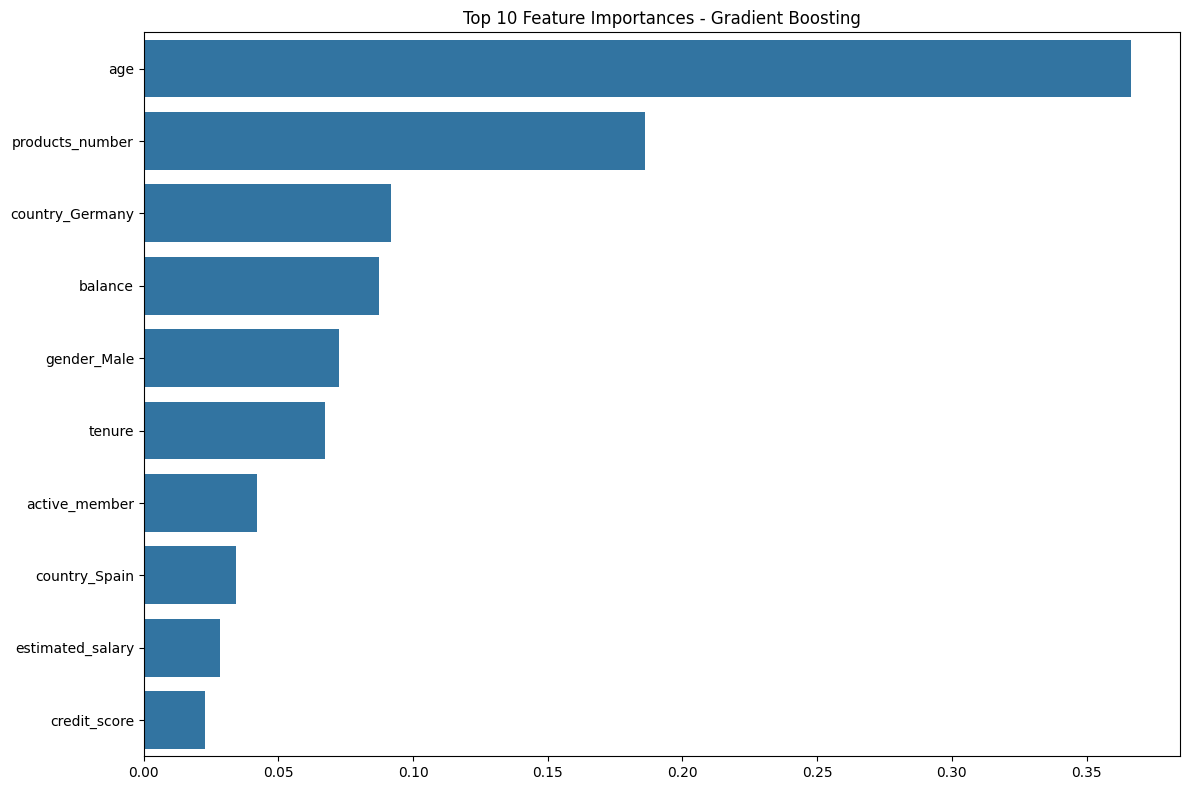

In [29]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importance[:10], y=sorted_feature_names[:10])
plt.title(f'Top 10 Feature Importances - {best_name}')
plt.tight_layout()
plt.savefig('figures/feature_importance.png')
plt.show()

## This plot shows the top 10 most important features for predicting customer churn according to our best model (Gradient Boosting).

1. Age (most important)
Age is the strongest predictor of churn. Older or younger customers (depending on the data distribution) are much more likely to leave the bank. The bank should analyze which age groups are at higher risk and tailor retention strategies accordingly.
2. Products Number
The number of products a customer holds is highly influential. Customers with fewer products are more likely to churn. Encouraging customers to use more products (cross-selling) can help reduce churn.
3. Country_Germany
Being a customer from Germany is a significant factor. German customers may have a higher tendency to churn compared to those from other countries. The bank should investigate country-specific reasons and consider targeted interventions...

### 7. Conclusions

1. **Churn Prediction**  
   Our Gradient Boosting model achieved strong performance:
   - **Accuracy**: 85.75%  
   - **ROC AUC**: 85.77%  
   - **PR AUC**: 70.73%  
   - **Recall for churn class**: 55%

2. **Key Churn Drivers**  
   - **Age** is the most influential factor. Older customers are more likely to churn.
   - Other top features: **Estimated Salary**, **Credit Score**, **Account Balance**.
   - Engagement metrics like **Number of Products** and **Active Membership** show strong correlation with retention.

3. **Customer Segments at Risk**  
   - Customers with **only one product**
   - **Non-active members**
   - **German customers** show higher churn propensity.